In [1]:
import sklearn
import torch
import ot
import sys

import numpy as np
import scipy.linalg as spl
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from tqdm import tqdm

import GMM_utils as GMM
import sliced_mw as SMW

from sliced_busemann_gaussian1d import sliced_1Dbusemann_GMM

sys.path.append("../")
from lib_torch.sliced_busemann_gaussian import busemann_sliced_gaussian

/home/clement/anaconda3/envs/py311/lib/python3.11/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
def compute_consecutive_distance(gmm_dict, distance="otgmm", k_min=2, k_max=10, n_projs=1000):
    pairwise_dist_dict = {}

    for k in range(k_min, k_max-1):
        m1 = gmm_dict[k].means
        m2 = gmm_dict[k+1].means
        covs1 = gmm_dict[k].covariances
        covs2 = gmm_dict[k+1].covariances
        w1 = gmm_dict[k].weights
        w2 = gmm_dict[k+1].weights

        if distance == "otgmm":
            pairwise_dist_dict[k] = ot.gmm.gmm_ot_loss(m1, m2, covs1, covs2, w1, w2)
        elif distance == "msw":
            pairwise_dist_dict[k] = SMW.calc_MSW(gmm_dict[k], gmm_dict[k+1], pnum=n_projs)
        elif distance == "swm":
            # pairwise_dist_dict[k] = SMW.calc_SMSW(gmm_dict[k], gmm_dict[k+1], pnum=n_projs)
            pairwise_dist_dict[k] = SMW.calc_parallel_SMSW(gmm_dict[k], gmm_dict[k+1], pnum=n_projs)
        elif distance == "swbg":
            pairwise_dist_dict[k] = busemann_sliced_gaussian(m1, m2, covs1, covs2, n_projs, u_weights=w1, v_weights=w2)
        elif distance == "swb1dg":
            pairwise_dist_dict[k] = sliced_1Dbusemann_GMM(m1, m2, covs1, covs2, n_projs, u_weights=w1, v_weights=w2)

    return pairwise_dist_dict

In [3]:
def run_xp(X, methods, labels, k_min=2, k_max=10, msize=10, groundtruth=None):
    gmm_dict = {}
    for k in range(k_min, k_max):
        gmm_dict[k] = GMM.FittedGaussianMixtureModel(X, k, n_init=20, device="cpu")

    plt.rcParams.update({'font.size': 25})

    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].scatter(X[:, 0], X[:, 1])
    ax[0].set_yticks([])
    ax[0].set_xticks([])

    if groundtruth is None:
        ax[0].set_xlabel("Dimension " + str(X.shape[-1]), usetex=True)
    else:
        ax[0].set_xlabel("Dimension " + str(X.shape[-1]) + ", K=" + str(groundtruth))

    for dist, label in zip(methods, labels):
        pairwise_dist_dict = compute_consecutive_distance(gmm_dict, distance=dist, k_min=k_min, k_max=k_max)
        
        ax[1].plot(pairwise_dist_dict.keys(), [d for d in pairwise_dist_dict.values()], 
                   marker="o",label="$" + str(label) + "(\mu_k, \mu_{k+1})$", markersize=msize)

    ax[1].set_xlabel("Components $k$", usetex=True)
    ax[1].set_xticks([2, 4, 6, 8])
    ax[1].set_yticks([])
    ax[1].set_ylim(bottom=0) 
    ax[1].legend(fontsize=18)
    plt.gcf().set_size_inches(10, 5)
    plt.show()

### Xp Setting (Piening and Beinert, 2025)

In [4]:
scaler = sklearn.preprocessing.StandardScaler()
n_samples = 1500
np.random.seed(42)
torch.manual_seed(42)
transformation = [[0.6, -0.2], [-0.4, 0.7]]

X_ls = []
X1, y = make_blobs(n_samples=n_samples, random_state=42, centers=4)
X_ls.append(scaler.fit_transform(X1))
X_ls.append(scaler.fit_transform(np.dot(X1, transformation)))  # Anisotropic blobs

X2, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2., 0.8, .5], random_state=43, centers=4
)  # Unequal variance
X_ls.append( scaler.fit_transform((X2)))

X1, y = make_blobs(n_samples=n_samples, random_state=40, centers=4, cluster_std=[.5, 1.3, 0.5, 1.3])
X_filtered = np.vstack(
    (X1[y == 0][:100], X1[y == 1][:500], X1[y == 2][:100], X1[y == 3][:500])
)  # Unevenly sized blobs
X_ls.append(scaler.fit_transform(X_filtered))

In [5]:
# methods = ["otgmm", "msw", "swm", "swbg", "swb1dg"]
# labels = ["\mathrm{W}_{\mathrm{BW}}", "\mathrm{MSW}", "\mathrm{DSMW}", "\mathrm{SWBG}", "\mathrm{SWB1DG}"]

# for i in range(len(X_ls)):
#     X = torch.tensor(X_ls[i])
#     run_xp(X, methods, labels)

In [6]:
def run_xp_plots(X, methods, labels, k_min=2, k_max=10, msize=10, groundtruth=None, ax=None, ymax=None):
    gmm_dict = {}
    for k in range(k_min, k_max):
        gmm_dict[k] = GMM.FittedGaussianMixtureModel(X, k, n_init=20, device="cpu")

    ax[0].scatter(X[:, 0], X[:, 1])
    ax[0].set_yticks([])
    ax[0].set_xticks([])

    if groundtruth is None:
        ax[0].set_xlabel("Dimension " + str(X.shape[-1]), usetex=True)
    else:
        ax[0].set_xlabel("Dimension " + str(X.shape[-1]) + ", K=" + str(groundtruth))

    for dist, label in zip(methods, labels):
        pairwise_dist_dict = compute_consecutive_distance(gmm_dict, distance=dist, k_min=k_min, k_max=k_max)
        
        ax[1].plot(pairwise_dist_dict.keys(), [d for d in pairwise_dist_dict.values()], 
                   marker="o", markersize=msize, label="$" + str(label)+ "$") # + "(\mu_k, \mu_{k+1})$")

        if dist == "otgmm":
            print(pairwise_dist_dict)

    ax[1].set_xticks([2, 4, 6, 8])
    ax[1].set_ylim(bottom=0)
    ax[1].set_ylim(0, ymax)
    ax[1].grid(True)
    # ax[1].legend(fontsize=18)

{2: tensor(1.5171), 3: tensor(0.2819), 4: tensor(0.0040), 5: tensor(0.0106), 6: tensor(0.0169), 7: tensor(0.0167), 8: tensor(0.0121)}


/home/clement/anaconda3/envs/py311/lib/python3.11/site-packages/ot/lp/solver_1d.py:46: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3675.)
  idx = nx.searchsorted(cws, qs).T


{2: tensor(0.3418), 3: tensor(0.1117), 4: tensor(0.0074), 5: tensor(0.0162), 6: tensor(0.0104), 7: tensor(0.0077), 8: tensor(0.0059)}
{2: tensor(1.0901), 3: tensor(0.5033), 4: tensor(0.0059), 5: tensor(0.0404), 6: tensor(0.0433), 7: tensor(0.0188), 8: tensor(0.0283)}
{2: tensor(1.0630), 3: tensor(0.1728), 4: tensor(0.0360), 5: tensor(0.0225), 6: tensor(0.0198), 7: tensor(0.0558), 8: tensor(0.0102)}


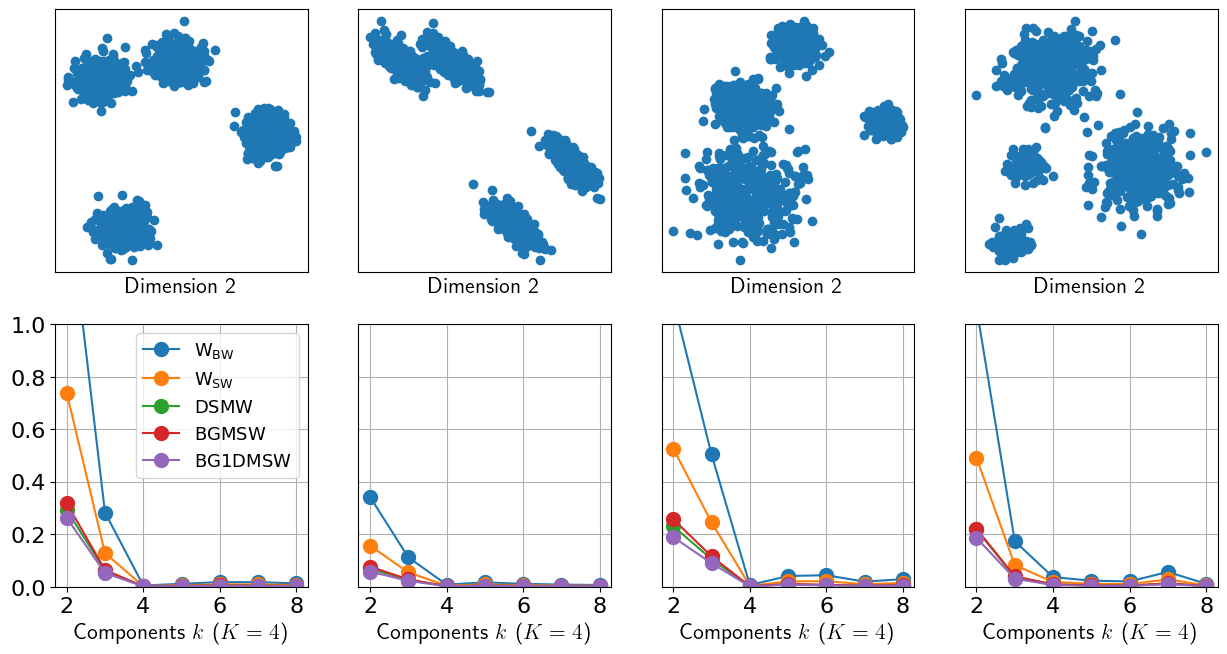

In [7]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(2, 4, figsize=(15, 7.5)) #, dpi=200)

methods = ["otgmm", "msw", "swm", "swbg", "swb1dg"]
labels = ["\mathrm{W}_{\mathrm{BW}}", "\mathrm{W}_\mathrm{SW}", "\mathrm{DSMW}", "\mathrm{BGMSW}", "\mathrm{BG1DMSW}"]

for i in range(len(X_ls)):
    X = torch.tensor(X_ls[i])
    run_xp_plots(X, methods, labels, ax=ax[:,i], ymax=1)

    ax[1,i].set_xlabel("Components $k$ ($K=4$)", usetex=True)
    
    if i == 0:
        ax[1,i].legend(fontsize=13)
    
    if i!=0:
        # ax[1,i].set_yticks([])
        # ax[1,i].set_yticklabels([])
        ax[1,i].tick_params(left=False, labelleft=False)

plt.savefig("Cluster_detection_d2.pdf", format="pdf", bbox_inches="tight")   # best for LaTeX
plt.show()

### Xp2

In [8]:
import torch.nn.functional as F

def sample_uniform_points_sphere(N, d, n_iter=100, lr=150):
    x0 = torch.randn(N, d)
    x0 = F.normalize(x0, dim=-1)
    
    x = x0.clone()
    x.requires_grad_(True)
    
    losses = []
    xvisu = torch.zeros(n_iter, N, d)
    
    for i in range(n_iter):
        sw = ot.sliced_wasserstein_sphere_unif(x, n_projections=500)
        grad_x = torch.autograd.grad(sw, x)[0]
    
        x = x - lr * grad_x / np.sqrt(i / 10 + 1)
        x = F.normalize(x, p=2, dim=1)

    return x.detach().cpu()

In [9]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler

def generate_random_gaussian_mixture(
    n_samples=1500, 
    n_components=4, 
    n_features=2, 
    min_separation=5.0, 
    random_state=None
):
    """
    Generate a dataset from a Gaussian mixture with random means and covariances,
    ensuring modes are reasonably separated.

    Parameters
    ----------
    n_samples : int
        Total number of samples.
    n_components : int
        Number of mixture components.
    n_features : int
        Dimensionality of the data.
    min_separation : float
        Minimum Euclidean distance between component means.
    random_state : int or None
        Random seed for reproducibility.

    Returns
    -------
    X : ndarray of shape (n_samples, n_features)
        The generated dataset.
    y : ndarray of shape (n_samples,)
        The component labels.
    params : dict
        Dictionary with means, covariances, and weights.
    """
    rng = np.random.default_rng(random_state)

    # Randomly generate mixture weights
    weights = rng.dirichlet(alpha=np.ones(n_components))
    samples_per_component = rng.multinomial(n_samples, weights)

    means = []
    for _ in range(n_components):
        # while True:
        #     candidate = rng.uniform(-10, 10, size=n_features)
        #     if all(np.linalg.norm(candidate - m) >= min_separation for m in means):
        #         means.append(candidate)
        #         break
        means = 100 * sample_uniform_points_sphere(n_components, n_features)

    print(len(means))

    X_list, y_list, covs = [], [], []

    for k, mean in enumerate(means):
        # Random SPD covariance
        A = rng.normal(size=(n_features, n_features))
        cov = np.dot(A, A.T) + np.eye(n_features) * 0.5
        covs.append(cov)

        Xk = rng.multivariate_normal(mean, cov, size=samples_per_component[k])
        yk = np.full(samples_per_component[k], k)

        X_list.append(Xk)
        y_list.append(yk)

    X = np.vstack(X_list)
    y = np.concatenate(y_list)

    # Normalize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    params = dict(means=np.array(means), covariances=np.array(covs), weights=weights)

    return X, y, params

In [10]:
# Example: generate a list of mixtures with different parameters
np.random.seed(42)
torch.manual_seed(42)

X_ls = []
configs = [
    dict(n_samples=1500, n_components=4, n_features=3, random_state=1),
    dict(n_samples=1000, n_components=6, n_features=5, random_state=3),
    dict(n_samples=2000, n_components=5, n_features=10, random_state=2),
    dict(n_samples=1000, n_components=6, n_features=20, random_state=42),
    # dict(n_samples=1000, n_components=6, n_features=10, random_state=42),
]

groundtruth = []
for cfg in configs:
    X, y, params = generate_random_gaussian_mixture(**cfg)
    X_ls.append(X)
    groundtruth.append(params["means"].shape[0])

4
6
5
6


{2: tensor(1.2973), 3: tensor(1.3118), 4: tensor(0.0054), 5: tensor(0.0009), 6: tensor(0.0066), 7: tensor(0.0018), 8: tensor(0.0027)}
{2: tensor(3.4829), 3: tensor(1.2237), 4: tensor(1.0039), 5: tensor(0.5306), 6: tensor(0.0009), 7: tensor(0.0070), 8: tensor(0.0049)}
{2: tensor(9.0608), 3: tensor(3.0743), 4: tensor(2.6566), 5: tensor(0.0113), 6: tensor(0.0061), 7: tensor(0.0088), 8: tensor(0.0121)}
{2: tensor(22.7255), 3: tensor(9.9861), 4: tensor(2.7118), 5: tensor(1.0868), 6: tensor(0.0632), 7: tensor(0.0377), 8: tensor(0.0561)}


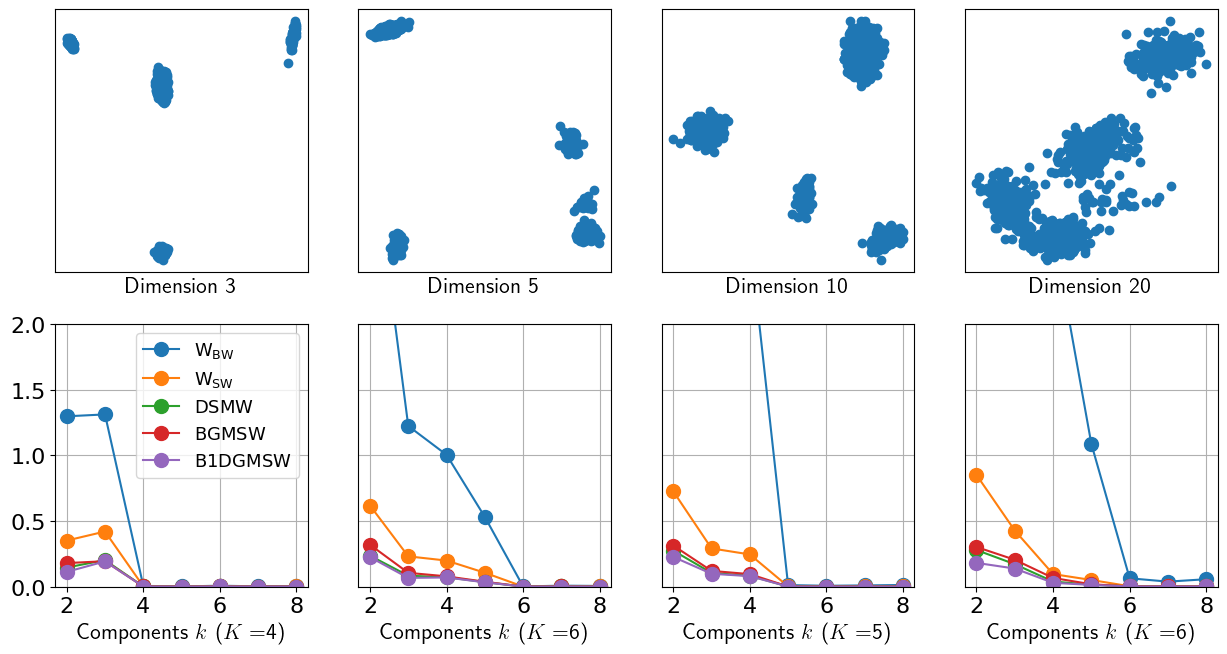

In [11]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 4, figsize=(15, 7.5))  #, dpi=200)

methods = ["otgmm", "msw", "swm", "swbg", "swb1dg"]
labels = ["\mathrm{W}_{\mathrm{BW}}", "\mathrm{W}_\mathrm{SW}", "\mathrm{DSMW}", "\mathrm{BGMSW}", "\mathrm{B1DGMSW}"]

for i in range(len(X_ls)):
    X = torch.tensor(X_ls[i])
    run_xp_plots(X, methods, labels, ax=ax[:,i], ymax=2)

    if i == 0:
        ax[1,i].legend(fontsize=13)

    
    if i!=0:
        # ax[1,i].set_yticks([])
        # ax[1,i].set_yticklabels([])
        ax[1,i].tick_params(left=False, labelleft=False)


    ax[1,i].set_xlabel("Components $k$ ($K=$"+str(groundtruth[i]) +")", usetex=True)

plt.savefig("Cluster_detection_higher_dim.pdf", format="pdf", bbox_inches="tight")   # best for LaTeX
plt.show()